 *by Gerard Caravaca Ibáñez*

## **TD3 implementation**

This notebook is an implementation of the TD3 algorithm for reinforcement learning, proposed in [1]. 

**TD3 (Twin Delayed Deep Deterministic Policy Gradient)** is a state-of-the-art reinforcement learning algorithm that is designed to learn continuous control policies in environments with high-dimensional state and action spaces. TD3 is an extension of the original DDPG algorithm, which was limited by its susceptibility to overestimation of the Q-function and sensitivity to hyperparameters.

TD3 improves upon DDPG by introducing several key modifications, including the use of twin Q-networks to reduce overestimation bias, delayed policy updates to improve stability, and target policy smoothing to reduce variance.


*[1] Fujimoto, S., Hoof, H., & Meger, D. (2018, July). Addressing function approximation error in actor-critic methods. In International conference on machine learning (pp. 1587-1596). PMLR.*

# **Imports**

In [ ]:
!pip install box2d-py
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  error: subprocess-exited-with-error
  
  × Running setup.py install for box2d-py did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for box2d-py ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> box2d-py

note: This is an issue with the package mentio

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
import gym
import os
import matplotlib.pyplot as plt
from gym.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from IPython import display

In [ ]:
print(tf.__version__)

2.12.0


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Replay Buffer**

The following class implements a **replay buffer** based on numpy memory arrays. This buffer is used to store experiences during the traininig phase. It allows the agent to learn from past experiences by randomly sampling a batch of transitions from the buffer, instead of relying solely on the most recent experience. In this case I have decided to set a memory limit to avoid overloading the device's RAM.

In particular this class implements two functions:

*   Store: is used to store an experience in the replay buffer. It takes as input a state, an action, a reward, a new state, and a boolean flag indicating whether the episode is done (done). It updates the buffers by storing the provided values at the current storage index (id) and increments the storage index.
*   Sample: is used to randomly sample a batch of experiences from the replay buffer. It takes as input the desired batch size. It first determines the maximum index to sample from, which is the minimum of the current storage index (self.curr_storage) and the maximum storage size (self.max_storage). It then randomly selects batch_size indices from the range of valid indices and uses them to retrieve corresponding samples from the state, action, reward, new state, and terminal buffers. Finally, it returns these samples as separate arrays.


In [ ]:
class ReplayBuffer:
  def __init__(self, max_size, input_shape, n_actions):
    self.max_storage = max_size
    self.curr_storage = 0
    self.curr_buffer = np.zeros((self.max_storage, *input_shape))
    self.new_buffer = np.zeros((self.max_storage, *input_shape))
    self.action_buffer = np.zeros((self.max_storage, n_actions))
    self.reward_buffer = np.zeros(self.max_storage)
    self.term_buffer = np.zeros(self.max_storage, dtype=bool)
  
  def store(self, state, action, reward, new_state, done):
    id = self.curr_storage % self.max_storage

    self.curr_buffer[id] = state
    self.new_buffer[id] = new_state
    self.action_buffer[id] = action
    self.reward_buffer[id] = reward
    self.term_buffer[id] = done

    self.curr_storage += 1
  
  def sample(self, batch_size):
    max = min(self.curr_storage, self.max_storage)
    batch = np.random.choice(max, batch_size)

    return self.curr_buffer[batch], self.action_buffer[batch], self.reward_buffer[batch], self.new_buffer[batch], self.term_buffer[batch]

# **Critic**

This class implements the critic neural network which approximates the Q-function taking into account the current state and action. This class overwrite the keras.Model class, taking this into account the init function initialize the model architecture and the call function do the forward pass throug the network. I decided to use a sequential network with 2 dense layers applying RELU function as activation.

**Important:** if you want to run this notebook, modify the *chkpt_dir* parameter. This refers to the address of the directory that will be used to store the models during training. 

In [ ]:
class Critic(keras.Model):
    def __init__(self, n1, n2, name='critic', chkpt_dir='/content/drive/MyDrive/MAI/ATCI/implementation/models'):
        super(Critic, self).__init__()
        self.l1_size = n1
        self.l2_size = n2
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        # Net architecture
        self.l1 = Dense(self.l1_size, activation='relu')
        self.l2 = Dense(self.l2_size, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state, action):
        q = self.l1(tf.concat([state, action], axis=1))
        q = self.l2(q)

        q = self.q(q)

        return q

# **Actor**

This class implements the actor neural networks which takes in the current state as input and outputs an action based on the current policy. All the concepts explained in the previous case also apply to this class.

**Important:** if you want to run this notebook, modify the *chkpt* parameter. This refers to the address of the directory that will be used to store the models during training. 

In [ ]:
class Actor(keras.Model):
    def __init__(self, n1, n2, n_actions, name='actor',
                 chkpt='/content/drive/MyDrive/MAI/ATCI/implementation/models'):
        super(Actor, self).__init__()
        self.l1_size = n1
        self.l2_size = n2
        self.n_actions = n_actions
        self.model_name = name
        self.checkpoint_dir = chkpt
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        # Net architecture
        self.l1 = Dense(self.l1_size, activation='relu')
        self.l2 = Dense(self.l2_size, activation='relu')
        self.mu = Dense(self.n_actions, activation='tanh')

    def call(self, state):
        prob = self.l1(state)
        prob = self.l2(prob)

        mu = self.mu(prob)

        return mu

# **Agent**

This class implements the complete agent,which learns to interact with an environment in order to achieve a specific goal. 

All the logic of the algorithm is implemented in this class. In this way, the three differential concepts of TD3 can be detected:

*   Twin Q-networks: It can be seen from the initialisation of the class that 2 Critic models are used. Moreover, in the training function the minimum Q of the two models is chosen (pessimistic q-learning).
*   Clipped action exploration: in the next action function it can be seen that some noise is introduced to the policy and that clipped exploration is implemented.
*   Delayed policy update: in the training function you can see that the actor is only updated when update_actor_interval indicates.

Following, each of the functions implemented in this class are explained:

* The __init__ method is the constructor of the Agent class. It initializes the agent with various parameters, such as learning rates (lr_a and lr_c), input shape (input_shape), the environment (env), update interval for the actor network (update_actor_interval), number of actions (n_actions), maximum size of the replay buffer (max_size), layer sizes for the actor and critic models (l1_size and l2_size), a parameter for soft target network updates (tau), and a name for the agent (name).

* The __next_action__ method is used to determine the next action to take based on the current observation. It takes as input an observation and optional parameters for noise (noise) and a discount factor (gamma). It first converts the observation to a tensor and passes it through the actor network (self.actor) to obtain the mean action (mu). Some noise is added to the mean action, and the resulting action is clipped to the valid action range. The method also increments the time step count.

* The __save_mem method__ is used to store an experience in the agent's replay buffer (self.replay_buffer). It takes as input a state, action, reward, new state, and done flag, and calls the store method of the replay buffer to store the experience.

* The __training__ method is used to train the agent's critic and actor networks. It takes an optional batch size (batch_size), soft target network update parameter (tau), and discount factor (gamma). If the replay buffer does not have enough experiences to form a batch, the method returns early. Otherwise, it samples a batch of experiences from the replay buffer. The states, actions, rewards, and new states are converted to tensors. Within a tf.GradientTape context, the target actions are computed by passing the new states through the target actor network (self.target_actor). Some noise is added to the target actions, which are then clipped to the valid action range. The target Q-values are computed by passing the new states and target actions through the target critic networks (self.target_critic1 and self.target_critic2). The current Q-values are obtained by passing the states and actions through the critic networks (self.critic1 and self.critic2). The minimum of the target Q-values is taken as the Q-value estimate. The critic loss is computed by comparing the target Q-values with the current Q-values. The loss is then used to compute the gradients for the critic networks (self.critic1 and self.critic2), and the optimizer is applied to update the critic networks' weights. The learn_step_count is incremented, and if it is not a multiple of update_actor_interval, the method returns early. Otherwise, within another tf.GradientTape context, the actor loss is computed by passing the states through the actor network (self.actor). The gradients for the actor network are computed using the actor loss, and the optimizer is applied to update the actor network's weights.

* Finally, the __update_network__ method is called to update the weights of the target networks (self.target_actor, self.target_critic1, and self.target_critic2) based on the current network weights.


One thing to note is that, although it can be clearly seen that for each model, the model itself uses an additional model called target, in practice only the main model is trained and the target model is a separate copy of the original network that is periodically updated to match the weights. This is done to improve the stability of the models in the training phase. 

Another tricky point is the use of the tf.squeeze function. This is used to size tensors from (batch_size,1) shape to (batch_size) shape.


In [ ]:
class Agent:
  def __init__(self, lr_a, lr_c, input_shape, env,
               update_actor_interval = 2,
               n_actions = 2, max_size = 1000000,
               l1_size=400, l2_size=300, tau=0.005, name=''):

    self.n_actions=n_actions
    
    self.replay_buffer = ReplayBuffer(max_size, input_shape, n_actions)
    
    self.update_actor_interval = update_actor_interval
    self.time_step = 0
    self.learn_step_count = 0
    self.max_action = env.action_space.high[0]
    self.min_action = env.action_space.low[0]

    # Needed networks
    self.actor = Actor(l1_size, l2_size, n_actions=n_actions, name='actor_'+name)
    self.critic1 = Critic(l1_size, l2_size, name='critic1_'+name)
    self.critic2 = Critic(l1_size, l2_size, name='critic2_'+name)
    self.target_actor = Actor(l1_size, l2_size, n_actions=n_actions, name='target_actor_'+name)
    self.target_critic1 = Critic(l1_size, l2_size, name='target_critic1_'+name)
    self.target_critic2 = Critic(l1_size, l2_size, name='target_critic2_'+name)

    # Optimizers
    opt_actor = Adam(learning_rate=lr_a)
    opt_critics = Adam(learning_rate=lr_c)

    self.actor.compile(optimizer=opt_actor, loss='mean')
    self.target_actor.compile(optimizer=opt_actor, loss='mean')
    self.critic1.compile(optimizer=opt_critics, loss='mean_squared_error')
    self.target_critic1.compile(optimizer=opt_critics, loss='mean_squared_error')
    self.critic2.compile(optimizer=opt_critics, loss='mean_squared_error')
    self.target_critic2.compile(optimizer=opt_critics, loss='mean_squared_error')

    self.update_network(tau=tau)
  
  def next_action(self, observation, noise=0.1, gamma=0.99):
    # Get policy with some noise
    state = tf.convert_to_tensor([observation], dtype=tf.float32)
    mu = self.actor(state)[0]
    mu_ = mu + np.random.normal(scale=noise)

    # Clipped action exploration
    mu_ = tf.clip_by_value(mu_, self.min_action, self.max_action)
    self.time_step += 1

    return mu_

  def save_mem(self, state, action, reward, new_state, done):
        self.replay_buffer.store(state, action, reward, new_state, done)
  
  def training(self, batch_size=100, tau=0.005, gamma=0.99):
    if self.replay_buffer.curr_storage < batch_size:
      return

    states, actions, rewards, new_states, dones = self.replay_buffer.sample(batch_size)

    # convert to tensor for training
    states = tf.convert_to_tensor(states, dtype=tf.float32)
    actions = tf.convert_to_tensor(actions, dtype=tf.float32)
    rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
    new_states = tf.convert_to_tensor(new_states, dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
      # Select action according to policy and add clipped noise 
      target_actions = self.target_actor(new_states)
      target_actions = target_actions + tf.clip_by_value(np.random.normal(scale=0.2), -0.5, 0.5)
      target_actions = tf.clip_by_value(target_actions, self.min_action,
                                        self.max_action)
      # Compute the target Q value
      q1_ = self.target_critic1(new_states, target_actions)
      q2_ = self.target_critic2(new_states, target_actions)
      q1 = tf.squeeze(self.critic1(states, actions), 1)
      q2 = tf.squeeze(self.critic2(states, actions), 1)
      # shape is [batch_size, 1], want to collapse to [batch_size],
      # squeeze removes dimensions of size 1 from the shape of a tensor.
      q1_ = tf.squeeze(q1_, 1)
      q2_ = tf.squeeze(q2_, 1)
      # pessimistic double-Q learning
      q = tf.math.minimum(q1_, q2_) 

      # Compute critic loss
      target = rewards + gamma*q*(1-dones)
      critic1_loss = keras.losses.MSE(target, q1)
      critic2_loss = keras.losses.MSE(target, q2)

    # Optimize the critic
    critic1_gradient = tape.gradient(critic1_loss,
                                self.critic1.trainable_variables)
    critic2_gradient = tape.gradient(critic2_loss,
                                self.critic2.trainable_variables)
    self.critic1.optimizer.apply_gradients(
          zip(critic1_gradient, self.critic1.trainable_variables))
    self.critic2.optimizer.apply_gradients(
          zip(critic2_gradient, self.critic2.trainable_variables))

    self.learn_step_count += 1

    # delayed policy update
    if self.learn_step_count % self.update_actor_interval != 0:
      return

    with tf.GradientTape() as tape:
      # Compute actor loss
      new_actions = self.actor(states)
      critic1_value = self.critic1(states, new_actions)
      actor_loss = -tf.math.reduce_mean(critic1_value)

    # Optimize the actor
    actor_gradient = tape.gradient(actor_loss, self.actor.trainable_variables)
    self.actor.optimizer.apply_gradients(zip(actor_gradient, self.actor.trainable_variables))

    self.update_network(tau=tau)

  def update_network(self, tau):
    # Update weights of a network
      weights = []
      targets = self.target_actor.weights
      for i, weight in enumerate(self.actor.weights):
          weights.append(weight * tau + targets[i]*(1-tau))

      self.target_actor.set_weights(weights)

      weights = []
      targets = self.target_critic1.weights
      for i, weight in enumerate(self.critic1.weights):
          weights.append(weight * tau + targets[i]*(1-tau))

      self.target_critic1.set_weights(weights)

      weights = []
      targets = self.target_critic2.weights
      for i, weight in enumerate(self.critic2.weights):
          weights.append(weight * tau + targets[i]*(1-tau))

      self.target_critic2.set_weights(weights)

  def save_models(self):
      print('Saving models ...')
      self.actor.save_weights(self.actor.checkpoint_file)
      self.critic1.save_weights(self.critic1.checkpoint_file)
      self.critic2.save_weights(self.critic2.checkpoint_file)
      self.target_actor.save_weights(self.target_actor.checkpoint_file)
      self.target_critic1.save_weights(self.target_critic1.checkpoint_file)
      self.target_critic2.save_weights(self.target_critic2.checkpoint_file)

  def load_models(self):
      print('Loading models ...')
      self.actor.load_weights(self.actor.checkpoint_file)
      self.critic1.load_weights(self.critic1.checkpoint_file)
      self.critic2.load_weights(self.critic2.checkpoint_file)
      self.target_actor.load_weights(self.target_actor.checkpoint_file)
      self.target_critic1.load_weights(self.target_critic1.checkpoint_file)
      self.target_critic2.load_weights(self.target_critic2.checkpoint_file)
    
  


# **Extra functions**

In this section you can see the functions that have been used to run the experiments.

Parameters

In [ ]:
ENV='Pendulum-v1'
LR_ACTOR=0.001
LR_CRITIC=0.002
GAMMA=0.99
TAU=0.005
NOISE=0.1
BATCH_SIZE=128
L1_SIZE=512
L2_SIZE=512
UPDATE_ACTOR_INTERVAL=2
N_ITERATIONS=300
MAX_SIZE=100000
EXP_NAME='pendulum'
SAVE_POINTS=[100, 200, 250, 300, 350, 400, 450]

Training function

The train function trains an agent in a gym environment using the Agent class. It performs a specified number of iterations. In each iteration, the agent interacts with the environment, collects experiences, and updates its critic and actor networks. The function keeps track of the scores achieved in each episode and the average scores over time. At the end of training, the trained agent, episode scores, and average scores are returned.

In [ ]:
def train():
  env = gym.make(ENV)

  agent = Agent(lr_a=LR_ACTOR, lr_c=LR_CRITIC, input_shape=env.observation_space.shape, env=env, update_actor_interval=UPDATE_ACTOR_INTERVAL,
                n_actions=env.action_space.shape[0], l1_size=L1_SIZE, l2_size=L2_SIZE, max_size=MAX_SIZE, name=EXP_NAME)

  best_score = env.reward_range[0]
  scores=[]
  avg_history=[]

  with tf.device('GPU:0'):
    tf.random.set_seed(123)
    for i in range(N_ITERATIONS):
      obs = env.reset()
      done = False
      score = 0
      while not done:
        action = agent.next_action(observation=obs, noise=NOISE, gamma=GAMMA)
        new_obs, reward, done, info = env.step(action)
        agent.save_mem(state=obs, action=action, reward=reward, new_state=new_obs, done=done)
        agent.training(batch_size=BATCH_SIZE, tau=TAU)
        score += reward
        obs = new_obs

      scores.append(score)
      # Mean of last 50 scores
      mean_score = np.mean(scores[-100:])

      if mean_score > best_score:
        best_score = mean_score

      if i in SAVE_POINTS:
        agent.save_models()

      avg_history.append(mean_score)
      print(f"# Episode: {i}, Reward: {score}, Mean reward: {mean_score}.")
    
    agent.save_models()
    env.close()

  return agent, scores, avg_history


Plot Training Curve

The show_curve function is used to visualize the training progress of an agent by plotting the average test reward over episodes. It takes two arguments: avg, which is a list representing the average test rewards at each episode, and score, which is a list representing the test scores achieved at each episode. The function creates a line plot with the x-axis representing the episode numbers and the y-axis representing the average test reward. The average test rewards are plotted in red, while the test scores are plotted in blue with reduced opacity. The function then displays the plot.

In [ ]:
def show_curve(avg, score):
  ep = [i  for i in range(len(avg))]
  plt.plot( range(len(avg)),avg,'r')
  plt.plot(score, color = 'b', alpha=0.5)
  plt.xlabel("Episode")
  plt.ylabel("Average Test Reward")
  plt.show()

Show Experiment Video


The show_video function is used to display a video file in the Jupyter Notebook environment. It looks for video files with the .mp4 extension in the "video" directory. If a video file is found, it reads the file, encodes it using base64, and displays it as an HTML5 video element. The video is set to autoplay, loop, and has controls for playback. The function uses the display and HTML functions from IPython to show the video. If no video file is found, it prints a message indicating that the video could not be found.

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

Test Learned Behavior


The test_behavior function is used to test the behavior of an agent in a gym environment and record a video of the agent's interactions.

In [ ]:
def test_behavior(agent):
  env = RecordVideo(gym.make(ENV,render_mode='rgb_array',new_step_api=True),'video',new_step_api=True)
    
  obs = env.reset()
  agent.load_models()
  while True:
      env.render()
      action = agent.next_action(observation=obs, noise=NOISE, gamma=GAMMA)
      new_obs, reward, done, truncated, info = env.step(action)
      if done or truncated: break
      obs = new_obs
  env.close()
  show_video()

Test Random Behavior


The random_behavior function is used to observe the behavior of an agent that takes random actions in a gym environment and record a video of its interactions. It does not rely on any pre-trained agent or specific algorithm.

In [ ]:
def random_behavior():
  env = RecordVideo(gym.make(ENV,render_mode='rgb_array',new_step_api=True),'video',new_step_api=True)

  observation = env.reset()

  for _ in range(300):
    env.render()
    action = env.action_space.sample() # this takes random actions
    observation, reward, terminated , truncated, info = env.step(action)
    if terminated or truncated:
      break
  env.close()
  show_video()

# **Experiments**

In order to test the algorithm I used two Gym environments: 

*   Pendulum
*   Lunar Lander in continious version

# **1-Pendulum**

In [ ]:
ENV='Pendulum-v1'
LR_ACTOR=0.001
LR_CRITIC=0.002
GAMMA=0.99
TAU=0.005
NOISE=0.1
BATCH_SIZE=128
L1_SIZE=512
L2_SIZE=512
UPDATE_ACTOR_INTERVAL=2
N_ITERATIONS=300
MAX_SIZE=100000
EXP_NAME='pendulum'

Behaviour before learning:

As expected, the initial behaviour of the untrained agent is totally random.

In [ ]:
random_behavior()

/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Training:

In [ ]:
agent, scores, avg_history = train()

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Episode: 0, Reward: -1562.7877723822164, Mean reward: -1562.7877723822164.
# Episode: 1, Reward: -1361.4354621836085, Mean reward: -1462.1116172829124.
# Episode: 2, Reward: -1343.92031217996, Mean reward: -1422.7145155819283.
# Episode: 3, Reward: -1356.8107492610375, Mean reward: -1406.2385740017057.
# Episode: 4, Reward: -1402.3624143374261, Mean reward: -1405.46334206885.
# Episode: 5, Reward: -1610.3995975035982, Mean reward: -1439.619384641308.
# Episode: 6, Reward: -1642.1109866652127, Mean reward: -1468.5467563590087.
# Episode: 7, Reward: -1426.276993509213, Mean reward: -1463.2630360027842.
# Episode: 8, Reward: -1526.5718965928436, Mean reward: -1470.297353846124.
# Episode: 9, Reward: -1601.0449361066994, Mean reward: -1483.3721120721816.
# Episode: 10, Reward: -1632.4195736371332, Mean reward: -1496.9218813053592.
# Episode: 11, Reward: -1618.3070587284117, Mean reward: -1507.0373127572802.
# Episode: 12, Reward: -1500.0601440474577, Mean reward: -1506.5006074719092.
# E

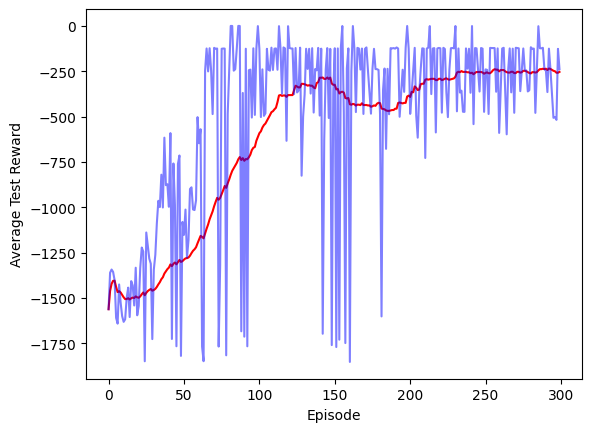

In [ ]:
show_curve(avg_history, scores)

This graph shows that the problem could be solved using 300 episodes. However, from episode 210 onwards, the results are very similar and the training stabilises. Although the agent has managed to learn to solve the problem in a reduced number of episodes, the learning line that the reward shows is quite unstable and has peaks. This may be due to the fact that the parameters used are not the most optimal.

In [ ]:
test_behavior(agent)

/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Loading models ...


This video shows how the agent has learned to use inertia effectively to achieve the fastest possible vertical positioning. Moreover, he manages to stay in that position, which is the objective of the problem.

# **2-LunarLander**

In [ ]:
ENV='LunarLanderContinuous-v2'
LR_ACTOR=0.001
LR_CRITIC=0.002
GAMMA=0.99
TAU=0.005
NOISE=0.1
BATCH_SIZE=128
L1_SIZE=512
L2_SIZE=512
UPDATE_ACTOR_INTERVAL=2
N_ITERATIONS=400
MAX_SIZE=100000
EXP_NAME='lunar'
SAVE_POINTS=[100, 200, 250, 300, 350, 400]

This video shows how the agent has learned to use inertia effectively to achieve the fastest possible vertical positioning. Moreover, he manages to stay in that position, which is the objective of the problem.

In [ ]:
random_behavior()

/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
agent, scores, avg_history = train()

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Episode: 0, Reward: -317.00588299169215, Mean reward: -317.00588299169215.
# Episode: 1, Reward: -421.27300686331415, Mean reward: -369.1394449275032.
# Episode: 2, Reward: -604.968276132241, Mean reward: -447.74905532908247.
# Episode: 3, Reward: -1057.7104739971176, Mean reward: -600.2394099960912.
# Episode: 4, Reward: -486.55860873379964, Mean reward: -577.503249743633.
# Episode: 5, Reward: -449.35420010037814, Mean reward: -556.1450748030904.
# Episode: 6, Reward: -713.9958220688386, Mean reward: -578.6951815553401.
# Episode: 7, Reward: -710.742066617938, Mean reward: -595.2010421881649.
# Episode: 8, Reward: -623.9746857697377, Mean reward: -598.3981136972285.
# Episode: 9, Reward: -671.0811449407813, Mean reward: -605.6664168215838.
# Episode: 10, Reward: -210.4783305659402, Mean reward: -569.7402271619799.
# Episode: 11, Reward: -115.0221911868141, Mean reward: -531.8470574973827.
# Episode: 12, Reward: -133.72554171374398, Mean reward: -501.22232551402584.
# Episode: 13, R

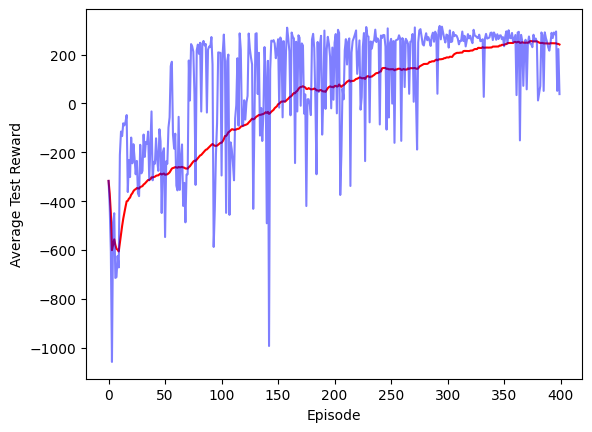

In [ ]:
show_curve(avg_history, scores)

In this case the training curve shows a more stable training which seems to indicate that the chosen parameters are more suitable for problems of this complexity. As can be seen, a stable reward of 200 has been reached with about 400 episodes. This seems to me to be a very positive result. 

The main problem with this environment is that by the time the agent learns to stay in the air, the episodes can be quite long-lasting, which means that training can be quite time-consuming. With this in mind I decided not to run the experiment again with more episodes even though the reward was still rising. Even so, this experiment allows us to see that the algorithm works as it should and that it is most likely that with more episodes the agent will be able to solve the environment.

In [ ]:
test_behavior(agent)

/usr/local/lib/python3.9/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Loading models ...


The video shows the behaviour learned by the agent after the training. As can be seen, the agent has learnt to descend with speed until a few moments before reaching the ground where it uses his propulsion to slow down his descent and to be able to land perfectly. At this point in the training, the agent needs to centre the landing a little more to the left. This is the point that I think it could learn with more episodes, as I have already explained.

# **Conclusions**

The TD3 (Twin Delayed DDPG) algorithm for reinforcement learning was implemented and evaluated in environments such as Pendulum-v1 and LunarLanderContinuous-v2. The experiments conducted demonstrated that TD3 can achieve high performance and generate robust results across a variety of tasks. The results indicate that TD3 is effective in learning policies that can successfully solve the given tasks. The agent trained using TD3 consistently achieved high rewards and demonstrated the ability to control the pendulum or land the lunar lander smoothly.

However, although the results show that the algorithm can learn useful policies with the set parameters, it is still possible for the algorithm to learn useful policies with the set parameters, it is important to note that the performance of TD3 can be sensitive to the choice of hyperparameters. This implies that fine-tuning of hyperparameters may be necessary to achieve optimal performance on specific tasks or environments.

Overall, the implementation of TD3 showcased its capability to learn effective policies in reinforcement learning tasks. The robustness of TD3 across different environments highlights its potential as a reliable algorithm for various real-world applications. Further research and experimentation can be conducted to explore additional environments and optimize the hyperparameters for improved performance.

